# **[Exploration 14] 프로젝트 : CIFAR-10 이미지 생성하기**

---

## **Google Drive 마운팅**

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import os
os.chdir('/content/drive/MyDrive/AIFFEL/Exploration/Ex14/')

<br><br>

## **주요 라이브러리 버전 확인**

---

In [52]:
import tensorflow
import imageio
import os

print(tensorflow.__version__)
print(imageio.__version__)

2.8.2
2.4.1


<br>

## **Step 1. 작업환경 구성하기 및 필요한 라이브러기 import 하기**
---

In [53]:
os.listdir()

['[E-14] Project.ipynb',
 'generated_samples',
 'training_history',
 'training_checkpoints',
 'README.md']

In [54]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.8.2


## **Step 2. 데이터셋 구성하기**
---


- CIFAR-10 데이터셋도 tf.keras 안에 있는 datasets에 포함되어 있어서, 아래와 같이 손쉽게 데이터셋을 구성할 수 있습니다.

In [55]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

```
def load_data(label=None):
    (train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()
    if label:
        df = pd.DataFrame(list(zip(train_x, train_y)), columns=['image', 'label']) 
        df = df[df['label']==label]
        train_x = np.array([i for i in list(df['image'])])
        df = pd.DataFrame(list(zip(test_x, test_y)), columns =['image', 'label']) 
        df = df[df['label']==label]
        test_x = np.array([i for i in list(df['image'])])
    return train_x, test_x
```

Fashion MNIST 또한 MNIST와 같이 28x28 픽셀의 이미지로, 각 픽셀은 0~255 사이의 정숫값을 가집니다. 한번 확인해 보시죠!

In [56]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


max값과 min값이 예상하던 대로 출력되었네요.
이번 프로젝트에서는 각 픽셀을 -1, 1로 정규화시켜서 사용할 예정이므로, 중간값을 0으로 맞춰주기 위해 127.5를 뺀 후 127.5로 나눠줍니다.

In [57]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [58]:
train_x.shape

(50000, 32, 32, 3)

딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요합니다. 입력되는 이미지 데이터의 채널 수는 어떤 이미지냐에 따라 달라지는데요, 컬러 이미지의 경우 R, G, B 세 개의 채널이 있고, Gray Scale(흑백)의 경우 1개의 채널만 존재합니다. `cifar-10` 데이터는 컬러 이미지이므로, 채널 값은 3이죠. 따라서 데이터셋의 shape 마지막에 3을 추가해 주도록 하겠습니다.

In [59]:
# train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
# train_x.shape

train_x = train_x.reshape(-1, 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

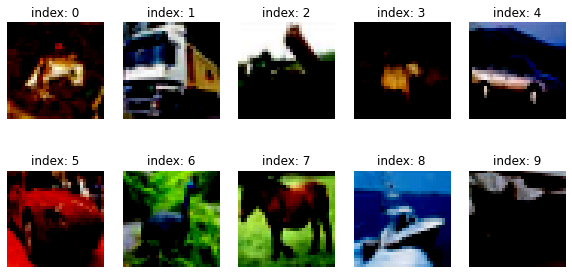

In [60]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

이제 데이터에 대한 전처리는 모두 마쳤습니다!

이렇게 정리된 데이터를 곧 모델에 넣어서 학습시켜야 하니, 편하게 사용할 수 있도록 텐서플로우의 Dataset을 이용해 준비해 놓도록 하겠습니다. 이를 이용하면 우리가 매번 모델에게 직접 섞어서 넣어주지 않아도 됩니다. 어떻게 사용하는지는 곧 보도록 하죠.

In [61]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정합니다. shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.

BATCH_SIZE는 모델이 한 번에 학습할 데이터의 양입니다.
너무 많은 양을 한 번에 학습시키면 메모리 활용 면에서도 비효율적이고, 한 번 학습을 하는 데에도 오래 걸리므로 적절한 사이즈로 잘라서 학습을 진행합니다. 이러한 방식을 미니 배치 학습 이라고 합니다.

In [62]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [63]:
for i in train_dataset:
    break

In [64]:
print('mini batch 사이즈는 :', i.shape[0])

mini batch 사이즈는 : 256


In [65]:
print('iteration 갯수는 :', len(train_dataset))

iteration 갯수는 : 196


## **Step 3. 생성자 모델 구현하기**

---

In [66]:
# 모델 구현은 keras의 Sequential API를 이용한다.

def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

레이어의 사이사이에 특정 층들이 반복되는 것을 확인할 수 있는데, BatchNormalization 레이어는 신경망의 가중치가 폭발하지 않도록 가중치 값을 정규화시켜줍니다. 또한 중간층들의 활성화 함수는 모두 LeakyReLU를 사용하였습니다. 다만 마지막 층에는 활성화 함수로 tanh를 사용하는데, 이는 우리가 -1 ~ 1 이내의 값으로 픽셀 값을 정규화시켰던 데이터셋과 동일하게 하기 위함입니다.

****Transpose Convolution의 출력크기****<br><br>

![image](https://user-images.githubusercontent.com/103712369/175077483-742a0139-4dee-42ec-9edc-3d1318222a3c.png)

In [67]:
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 128)       

그럼 모델이 만들어졌으니, shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성해서 결과물을 한번 만들어 보도록 하겠습니다.
아직 모델이 학습되지 않았으니, 아마 결과물도 큰 의미가 있지는 않을 것입니다.

tf.random.normal을 이용하면 가우시안 분포에서 뽑아낸 랜덤 벡터로 이루어진 노이즈 벡터를 만들 수 있습니다.



In [68]:
noise = tf.random.normal([1, 100])
noise.shape

TensorShape([1, 100])

In [69]:
print(noise.numpy().max())
print(noise.numpy().min())

1.8201541
-2.570001


- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 보자

In [70]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

In [71]:
print(generated_image.numpy().max())
print(generated_image.numpy().min())

0.06363448
-0.0556522


[1, 32, 32, 3] 사이즈의 이미지가 잘 생성되었군요!
첫 번째 1은 1개(batch_size=1)라는 뜻을, 그 뒤로는 (32, 32, 3) 사이즈 이미지가 생성되었다는 뜻을 가집니다.

그러면 이 이미지를 또 시각화해서 봐야겠습니다.
matplotlib 라이브러리는 2차원 이미지만 보여줄 수 있으므로 0번째와 3번째 축의 인덱스를 0으로 설정해서 (32, 32) shape의 이미지를 꺼낼 수 있도록 해야 합니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


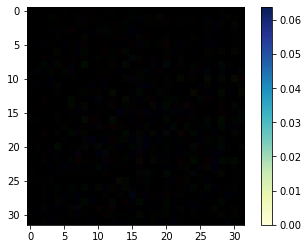

In [72]:
plt.imshow(np.reshape(generated_image, (32, 32, 3)), cmap='YlGnBu')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


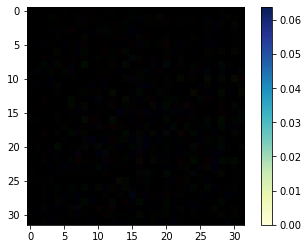

In [73]:
plt.imshow(tf.squeeze(generated_image, 0), cmap='YlGnBu')
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


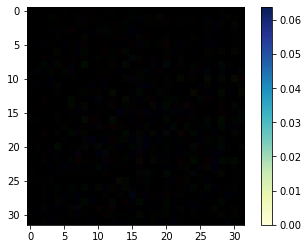

In [74]:
plt.imshow(generated_image[0], cmap='YlGnBu')
plt.colorbar()
plt.show()

### **Step 4. 판별자 모델 구현하기**
---


판별자는 앞서 알아봤듯 가짜 이미지와 진짜 이미지를 입력받으면 각 이미지 별로 '진짜라고 판단하는 정도'값을 출력해야 합니다.<br><br> 
그렇다면 입력은 (32, 32, 3) 크기의 이미지가, 출력은 단 하나의 숫자(진짜라고 판단하는 정도)가 될 것입니다.

In [75]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

Conv2DTranspose 층을 사용해서 이미지를 키워나갔던 생성자와 반대로, 판별자는 Conv2D 층으로 이미지의 크기를 점점 줄여나갑니다.
첫 번째 Conv2D 층에서 입력된 [32, 32, 3] 사이즈의 이미지는 다음 층을 거치며 (32, 32, 3) → (16, 16, 64) → (8, 8, 128)까지 줄어들게 됩니다.

마지막에는 Flatten 층을 사용해 3차원 이미지를 1차원으로 쭉 펴서 8x8x128=8192‬, 즉 (1, 8192‬) 형상의 벡터로 변환합니다. 이는 생성자의 Reshape 층에서 1차원 벡터를 3차원으로 변환했던 것과 정확히 반대 역할을 합니다. 1차원 벡터로 변환한 후에는 마지막 Dense Layer를 거쳐 단 하나의 값을 출력하게 됩니다.

In [76]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)             

그렇다면 아까 생성했던 가짜 이미지를 판별자에 입력시키면 어떤 결과가 나올까요? 바로 확인해 봅시다.



In [77]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00353008]], dtype=float32)>

In [78]:
decision.numpy()

array([[-0.00353008]], dtype=float32)

## Step 5. 손실함수와 최적화 함수 구현하기
---

딥러닝 모델이 학습하기 위해서 꼭 필요한 두 가지는, 바로 손실함수(loss function)와 최적화 함수(optimizer)죠.<br><br>

### **손실함수(loss function)**

---
GAN은 손실함수로 **교차 엔트로피(Cross Entropy)**를 사용합니다.  
교차 엔트로피는 앞서 분류 모델을 설계할 때 많이 사용했던 손실함수이죠.<br>점점 가까워지기 원하는 두 값이 얼마나 큰 차이가 나는지를 정량적으로 계산할 때 많이 쓰입니다. <br>특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, **이진 교차 엔트로피(binary cross entropy)**를 사용할 것입니다.

- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것<br><br>
- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

그런데 tf.keras.losses의 BinaryCrossEntropy 클래스는 기본적으로 본인에게 들어오는 인풋값이 0-1 사이에 분포하는 확률값이라고 가정합니다 ([참고](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy#args_1)). 따라서 ***from_logits를 True***로 설정해 주어야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 0~1 사이의 값으로 정규화한 후 알맞게 계산할 수 있습니다.

In [79]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

그럼, 이제 cross_entropy를 활용해 계산할 loss들은 fake_output와 real_output, 두 가지를 활용합니다.

- fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)<br><br>
- real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)

***generator_loss***<br><br>
그러면 generator_loss는 다음과 같이 구현할 수 있겠군요.

generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
즉, cross_entropy(tf.ones_like(fake_output), fake_output) 값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

In [80]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

***discriminator_loss***<br><br>
반면, discriminator_loss는 real_output 값은 1에 가까워지기를, fake_output 값은 0에 가까워지기를 바라므로, 두 가지 loss값을 모두 계산합니다. real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교하면 되겠죠!

최종 discriminator_loss 값은 이 둘을 더한 값입니다.

In [81]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

***discriminator accuracy***<br><br>
한편, 판별자가 real output, fake output을 얼마나 정확히 판별하는지의 accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요합니다. 특히 두 accuracy를 따로 계산해서 비교해 보는 것이 매우 유용합니다.

만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 것일까요? 그렇지 않습니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻입니다. 그래서, real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻입니다.

In [82]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 최적화 함수(optimizer)

---
자.. 그럼 손실함수는 모두 설계가 되었고, 이제 최적화 함수를 설정할 차례입니다. 이번에는 **Adam 최적화 기법**을 활용해 보겠습니다.  

Adam 함수 또한 tf.keras.optimizers 안에 있습니다.
중요한 하이퍼 파라미터인 "learning rate"는 0.0001로 설정할 텐데, 학습 품질을 올려보고 싶다면 여러 가지로 값을 바꾸어 가며 학습을 진행해 보는 것을 추천합니다.

또한, 중요한 점 한 가지는 생성자와 구분자는 따로따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어주어야 한다는 점입니다.

In [83]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

또한, 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인할 것입니다.

샘플은 한 번에 16장을 생성하도록 하겠습니다.<br><br>
***생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈를 만들어두어야 합니다.***<br><br>
즉, 100차원의 노이즈를 총 16개, (16, 100) 형상의 벡터를 만들어 두도록 하겠습니다.

In [84]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## Step 6. 훈련과정 상세 기능 구현하기
---

***(1) 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.***

In [85]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

***(2) 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 `generate_and_save_images()` 함수를 구현해 봅시다.***

In [86]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig('{}/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.path.join(current_path, 'generated_samples'), epoch, it))

    plt.show()

***(3) 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.***

In [87]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/train_history_{:04d}.png'
                    .format(os.path.join(current_path, 'training_history'), epoch))
    plt.show()

**(4) training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.**

**정기적으로 모델을 저장하기 위한 checkpoint**


- `tf.train.Checkpoint`를 사용하면 매번 모델을 저장해주지 않아도, 코드 한 줄로 빠르고 편하게 버전 관리 가능.


- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장함.
    
    - 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장하는 것.

In [88]:
import os
os.chdir('/content/drive/MyDrive/AIFFEL/Exploration/Ex14/')

In [89]:
current_path = os.getcwd()
current_path


'/content/drive/MyDrive/AIFFEL/Exploration/Ex14'

In [90]:
checkpoint_dir = os.path.join(current_path, 'training_checkpoints')

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

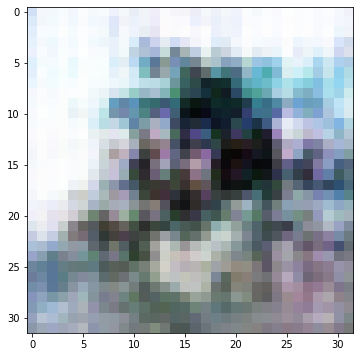

In [91]:
checkpoint_dir = os.path.join(current_path, 'training_checkpoints')

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

## **Step 7. 학습 과정 진행하기**
---

In [92]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [93]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

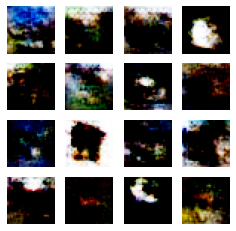

Epoch 65 | iter 1
Time for epoch 65 : 1 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

## **결론 및 회고**
---

- 이번 프로젝트에서는 CIFAR-10의 이미지를 불러와서 DCAGN 모델을 이용하여 이미지를 생성해보는 과정을 진행하였다. 


- 전체과정은 앞에 세션(앞쪽 노드)에서 진행된 과정과 크게 다르진 않아서 진행하는데 어려움은 크게 없었다. 다만 GAN이라는 개념과 모델구조 등 처음 접해보는 내용이라 이해하고 코드를 따라쳐보고 하는데 많은 시간이 소요되었다.


- 내가 CV를 선택한 이유 중 가장 크게 작용하였던 부분이 바로 생성모델 즉, GAN 때문이지 않을까 싶다. 아직 딥러닝이라는 분야를 이해하지 못하였고 내가 이 기술을 배워서 어떻게 사용하고 써먹어야 겠다라는 구체적인 목표(?) 계획(?)이 없다. 때문에, 매 프로젝트를 진행하는데 조금 회의적일 때가 있다. 하지만 그중에서 가장 흥미를 고무시켜주었던 분야가 바로 이 생성모델 분야이다. 향후 아이펠 과정에서 습득한 개념을 더욱 심화시켜 나간다면 CV 계열이고 GAN 내용이지 않을까? <br><br>


***GAN 훈련과정을 개선해보자***

- GAN 훈련과정을 개선해보기 위해 [github링크](https://github.com/soumith/ganhacks)를 참고하였다. 

- 위 링크의 내용에서 
1. 입력값을 정규화하기 라는 내용이 있었다. 
   - 우리의 DCGAN 모델을 학습하기 위해서 Train_x의 값을 -1~1의 범위를 갖도록 정규화를 진행해주었다. 
   - 또한 Generate 모델에서 마지막 층에 tanh 함수를 적용하여 값이 -1 ~ 1 사이의 값으로 매핑하였다.
   - 또한 layer 사이사이에 batch normailization을 수행하였다.

2. 모델은 DCGAN 모델을 사용하였다.
3. ADAM optimizer를 사용하였고, learning_rate 조정은 시도하지 않았지만 momentum 을 default 0.9에서 0.5로 낮추어 시도해보았다.